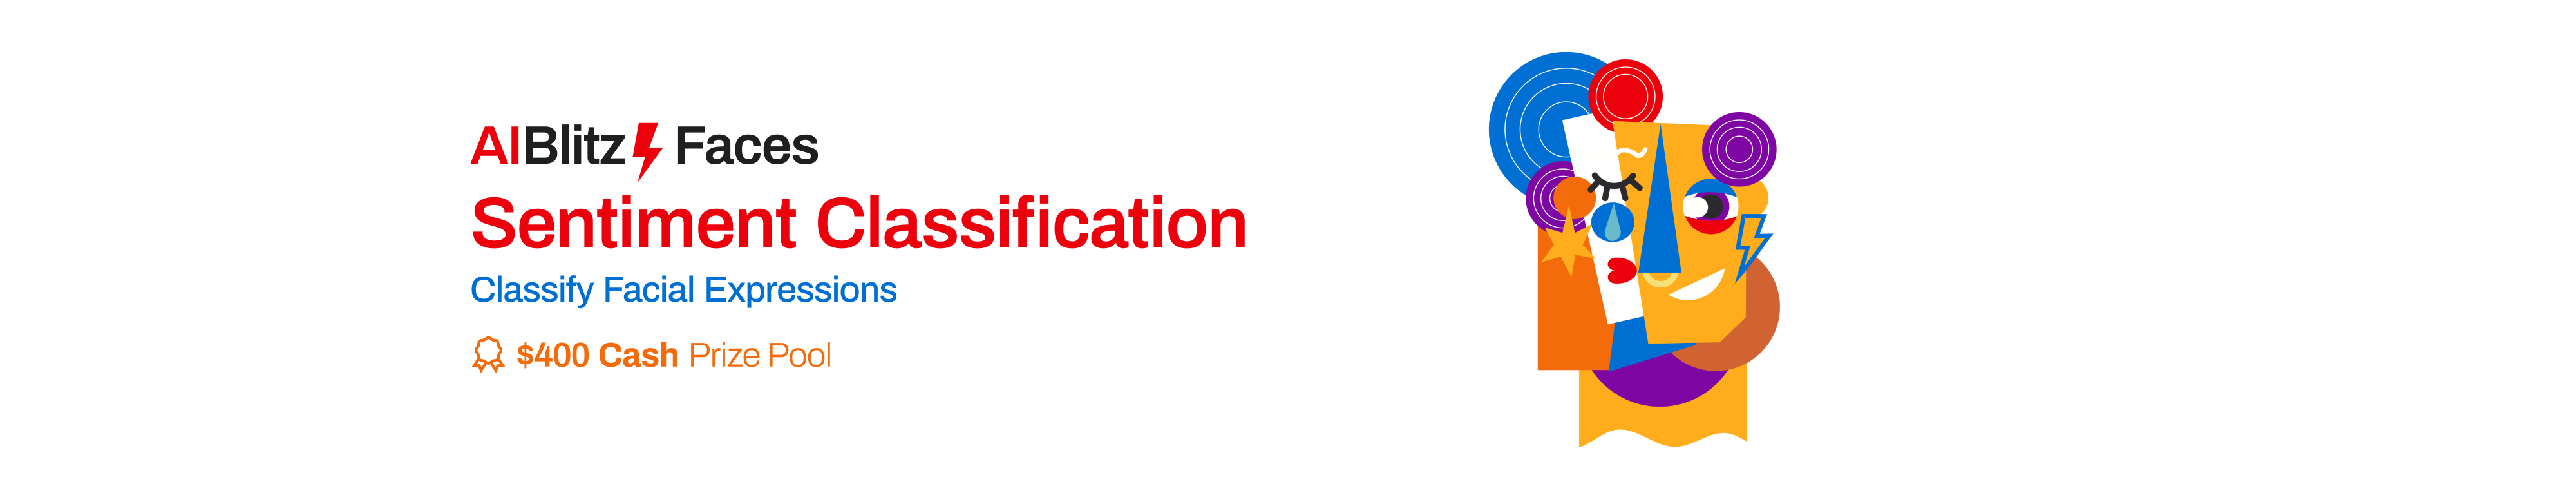

<h2><center> Getting Started with Sentiment Classification</center></h2>

In this puzzle, we have to classify the sentiment into 3 classes, positive, negative and neutral from the given features of an human face. 

This is a starter kit explaining how to download the data and also submit direcly via this notebook. 

We will be submitting the sample prediction directly in the required format.





# Download the files 💾¶
## Download AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic


## Login to AIcrowd ㊗¶


In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/qH77uJsTLp41OKMCCsrcY1DOd2H1-_sGjbT-Ln9XrMA
API Key valid
Gitlab access token valid
Saved details successfully!



## Download Dataset¶

We will create a folder name data and download the files there.


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c sentiment-classification -o data

sample_submission.csv:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/51.5M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/20.6M [00:00<?, ?B/s]

## Importing Libraries:

In [ ]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Diving in the dataset 🕵️‍♂️

In [ ]:
!pip install tensorflow_addons

In [ ]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

In [ ]:
from ast import literal_eval
# convert string as list
train_df.embeddings = train_df.embeddings.apply(literal_eval)
val_df.embeddings = val_df.embeddings.apply(literal_eval)

In [ ]:
# map the output into number
codes = {'positive': 2, 'negative': 0, 'neutral': 1}
train_df['label_num'] = train_df['label'].map(codes)
val_df['label_num'] = val_df['label'].map(codes)

# set labels and number as an individual set
train_df_label = train_df[['label_num', 'label']].copy()
val_df_label = val_df[['label_num', 'label']].copy()

In [ ]:
X_train = np.stack(train_df['embeddings'])
# X_train = np.expand_dims(X_train, axis=1)
X_train = X_train[..., np.newaxis]

# y_train = np.array(train_df['label_num'])
# y_train = y_train[..., np.newaxis]
y_train = pd.get_dummies(train_df_label['label'])
y_train = np.array(y_train)

In [ ]:
X_val = np.stack(val_df['embeddings'])
# X_val = np.expand_dims(X_val, axis=1)
X_val = X_val[..., np.newaxis]

# y_val = np.array(val_df['label_num'])
# y_val = y_val[..., np.newaxis]
y_val = pd.get_dummies(val_df_label['label'])
y_val = np.array(y_val)

In [ ]:
def df_to_dataset(dataframe
                  , target_col
                  , label_col
                  , shuffle=True
                  , batch_size=32):
  
  '''
  define functions to convert dataframe into tensorflow data pipeline
  so that it could fit in the DL pipeline
  '''
  
  df = dataframe.copy()
  # originally, the embedding column is a list contains 512 features
  # stack the feature so that (n, number of features)
  target = np.stack(df[target_col]).T
  labels = df.pop(label_col)

  # define a dictionary that item name as 
  df = {'feature_' + str(idx + 1): value.reshape(-1, 1) \
        for idx, value in enumerate(target)}
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
# apply the pipeline into current dataset
target_col, label_col, batch_size = 'embeddings', 'label_num', 10
train_df_batch = df_to_dataset(train_df
                               , target_col = target_col
                               , label_col = label_col
                               , batch_size = batch_size)

val_df_batch = df_to_dataset(val_df
                            , target_col = target_col
                            , label_col = label_col
                            , batch_size = batch_size)

# 3. Model

## 3.1 GRU

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 128, kernel_size=8
                        , padding = 'valid'
                        , input_shape = [None, 1]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(3, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 128)         1152      
                                                                 
 gru_10 (GRU)                (None, None, 128)         99072     
                                                                 
 gru_11 (GRU)                (None, 128)               99072     
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 199,683
Trainable params: 199,683
Non-trainable params: 0
_________________________________________________________________


In [ ]:
metric_f1 = tfa.metrics.F1Score(num_classes=3, threshold=0.5)

In [ ]:
model.compile(loss = 'categorical_crossentropy'
              , optimizer = 'adam', metrics = [metric_f1, 'accuracy'])

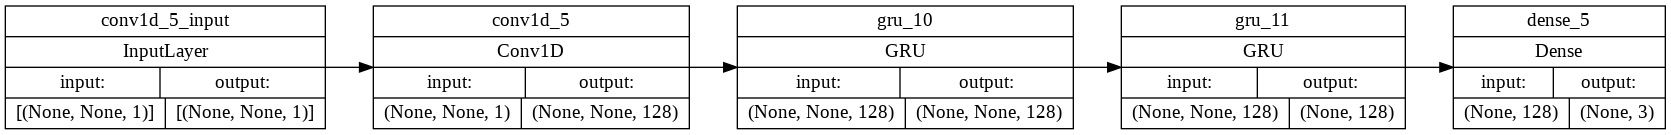

In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.fit(X_train, y_train
          , epochs=10, batch_size = 32
          , validation_data= (X_val, y_val))

Epoch 1/10
157/157 [==============================] - 166s 1s/step - loss: 0.9492 - f1_score: 0.3433 - accuracy: 0.5102 - val_loss: 0.9091 - val_f1_score: 0.3951 - val_accuracy: 0.5550
Epoch 2/10
157/157 [==============================] - 161s 1s/step - loss: 0.8745 - f1_score: 0.4505 - accuracy: 0.5692 - val_loss: 0.8664 - val_f1_score: 0.4129 - val_accuracy: 0.5820
Epoch 3/10
157/157 [==============================] - 161s 1s/step - loss: 0.8586 - f1_score: 0.4560 - accuracy: 0.5848 - val_loss: 0.8315 - val_f1_score: 0.4775 - val_accuracy: 0.5920
Epoch 4/10
157/157 [==============================] - 172s 1s/step - loss: 0.8339 - f1_score: 0.5026 - accuracy: 0.5966 - val_loss: 0.8549 - val_f1_score: 0.5387 - val_accuracy: 0.5870
Epoch 5/10
157/157 [==============================] - 162s 1s/step - loss: 0.8123 - f1_score: 0.5257 - accuracy: 0.6116 - val_loss: 0.8307 - val_f1_score: 0.5120 - val_accuracy: 0.6040
Epoch 6/10
157/157 [==============================] - 164s 1s/step - loss: 

## 3.2 Dense Only

In [ ]:
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [512, 1]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(3, activation = 'softmax')
])

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model2.compile(loss="categorical_crossentropy"
              , optimizer="nadam"
              , metrics=[metric_f1, "accuracy"])

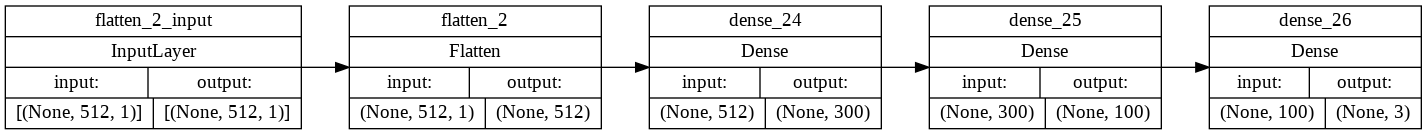

In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model2, show_shapes=True, rankdir="LR")

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

history = model2.fit(X_train, y_train, epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler, early_stopping_cb])

Epoch 1/50
157/157 [==============================] - 2s 11ms/step - loss: 32.4350 - f1_score: 0.3077 - accuracy: 0.3448 - val_loss: 2.1722 - val_f1_score: 0.1603 - val_accuracy: 0.3165 - lr: 0.0100
Epoch 2/50
157/157 [==============================] - 2s 12ms/step - loss: 1.1862 - f1_score: 0.2510 - accuracy: 0.3870 - val_loss: 1.0204 - val_f1_score: 0.2807 - val_accuracy: 0.4800 - lr: 0.0089
Epoch 3/50
157/157 [==============================] - 2s 13ms/step - loss: 1.0578 - f1_score: 0.2861 - accuracy: 0.4512 - val_loss: 0.9810 - val_f1_score: 0.2443 - val_accuracy: 0.4370 - lr: 0.0079
Epoch 4/50
157/157 [==============================] - 2s 16ms/step - loss: 0.9430 - f1_score: 0.3462 - accuracy: 0.5124 - val_loss: 0.9791 - val_f1_score: 0.4022 - val_accuracy: 0.5420 - lr: 0.0071
Epoch 5/50
157/157 [==============================] - 2s 13ms/step - loss: 0.8857 - f1_score: 0.3596 - accuracy: 0.5166 - val_loss: 1.1534 - val_f1_score: 0.2676 - val_accuracy: 0.3990 - lr: 0.0063
Epoch 6/5

## Generating Prediction File

In this starter kit we will directly be submitting the sample prediction file. In case you would like to see a submission via baseline model, check it out here. 

In [ ]:
test_df['embeddings'] = test_df['embeddings'].apply(literal_eval)

In [ ]:
X_test = np.stack(test_df['embeddings'])
# X_train = np.expand_dims(X_train, axis=1)
X_test = X_test[..., np.newaxis]

In [ ]:
# make prediction
y_test = model.predict(X_test)

# map back the label with code
codes_T = {2: 'positive', 0: 'negative', 1: 'neutral'}
y_test_label = y_test.argmax(axis = 1)
y_test_label = np.vectorize(codes_T.get)(y_test_label)

In [ ]:
# make prediction
y_test_2 = model2.predict(X_test)

# map back the label with code
codes_T = {2: 'positive', 0: 'negative', 1: 'neutral'}
y_test_label = y_test_2.argmax(axis = 1)
y_test_label = np.vectorize(codes_T.get)(y_test_label)

In [ ]:
test_df['label'] = y_test_label

In [ ]:
!rm -rf assets
!mkdir assets
test_df.to_csv(os.path.join("assets", "submission.csv"))


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [ ]:
%aicrowd notebook submit -c sentiment-classification -a assets --no-verify

Using notebook: AI_Blix13_01_Sentiment Classification  for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                       
                                                       │ Successfully submitted! │                                                       
                                                       ╰─────────────────────────╯

                                                             Important links                                                             
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/sentiment-classification/submissions/173727              │
│                  │                                                                                                                    │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/sentiment-classification/submissions?my_submissions=true │
│                  │                                                                                                                    │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/sentiment-classification/leaderboards                    │
│                  │                                                                                                                    │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xiii                                                                      │
│                  │                                                                                                                    │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/sentiment-classification                                 │
└──────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘